<a href="https://colab.research.google.com/github/fowardelcac/Markowitz/blob/main/Notebooks/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import yfinance as yf
import scipy.optimize as sci_opt

In [2]:
def tickers(n):
  lista_tickers = []
  for i in range(n):
    ticker = str(input("Ingrese el ticker: "))
    lista_tickers.append(ticker.upper())
  return lista_tickers  

def descarga(lista, fecha = str):
  n = len(lista)
  assets_df = []
  for i in lista:
    df = yf.download(i, start = fecha)['Adj Close']
    assets_df.append(df)
  return assets_df

def calculos(weights: list):
  ret = np.sum(ret_log.mean() * weights) * 252
  vol = np.sqrt(np.dot(weights.T, np.dot(ret_log.cov() * 252, weights)))
  sr = ret / vol
  return np.array([ret, vol, sr])

def neg_s(weights: list) -> np.array:
  return calculos(weights)[2] - 1

def get_vol(weights: list)-> np.array:
  return calculos(weights)[1]

    
def montecarlo(n_iter, n_stocks):
  portfolio_returns, portfolio_volatilities, portfolio_sharpe  = [list() for _ in range(3)]
  all_weights = np.zeros((n_iter, n_stocks))

  for i in range(n_iter):
  
    weights = np.random.random(n_stocks)
    weights = weights / np.sum(weights)

    all_weights[i, :] = weights
    rdo = calculos(weights)
    portfolio_returns.append(rdo[0])
    portfolio_volatilities.append(rdo[1])
    portfolio_sharpe.append(rdo[2])

  return pd.DataFrame({
      'Return': portfolio_returns,
      'Volatility': portfolio_volatilities,
      'Sharpe': portfolio_sharpe,
      'Weights': all_weights.tolist()
      })

In [3]:
assets = tickers(3)
assets_df = descarga(assets, '2015-01-01')

df = pd.concat(assets_df, axis= 1)
df.columns = assets

df.dropna(inplace=True)

Ingrese el ticker: aapl
Ingrese el ticker: msft
Ingrese el ticker: tsla
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
ret_log = np.log(df / df.shift(1))

In [5]:
df_portafolio = montecarlo(1000, len(assets))
df_portafolio.head(2)

,Return,Volatility,Sharpe,Weights
0,0.275876,0.317467,0.868991,"[0.15511313190718476, 0.4995426948186294, 0.34..."
1,0.260615,0.286410,0.909936,"[0.4461643882577842, 0.34978145869908933, 0.20..."


In [6]:
max_sh = df_portafolio.iloc[df_portafolio.Sharpe.idxmax()]
min_vol = df_portafolio.iloc[df_portafolio.Volatility.idxmin()]
max_ret = df_portafolio.iloc[df_portafolio.Return.idxmax()]

In [7]:
fig = px.scatter(df_portafolio, x='Volatility', y='Return', color='Sharpe',
                 labels={'Volatility': 'Expected Volatility', 'Return': 'Expected Return'},
                 title='Portfolio Optimization',
                 hover_data={'Volatility': True, 'Return': True, 'Sharpe': True})

fig.add_scatter(x=[min_vol[1]], y=[min_vol[0]], mode='markers', marker=dict(color='red', symbol='star'), name='Minimum Expected Volatility')
fig.add_scatter(x=[max_ret[1]], y=[max_ret[0]], mode='markers', marker=dict(color='red', symbol='star'), name='Maximum Expected Return')
fig.add_scatter(x=[max_sh[1]], y=[max_sh[0]], mode='markers', marker=dict(color='red', symbol='square'), name='Maximum Sharpe Ratio')

fig.update_layout(
    coloraxis=dict(colorscale='plasma', colorbar=dict(title='Sharpe Ratio')),
    legend=dict(
        title=None,
        orientation='h',
        yanchor='bottom',
        y=-0.2,
        xanchor='right',
        x=1
    ),
    margin=dict(l=0, r=0, t=30, b=0),
    showlegend=True,
    hovermode='closest',
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(showgrid=True, title_font=dict(size=12)),
    yaxis=dict(showgrid=True, title_font=dict(size=12)),
)

fig.show()


In [8]:
bounds = tuple((0, 1) for symbol in range(len(assets)))
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
init_guess = len(assets) * [1 / len(assets)]

optimized_sharpe = sci_opt.minimize(
    neg_s, 
    init_guess, 
    method='SLSQP',
    bounds=bounds, 
    constraints=constraints
)
      
optimized_metrics = calculos(weights=optimized_sharpe.x)
print('OPTIMIZED METRICS:')
print(optimized_metrics)
print('-'*80)
print('OPTIMIZED WEIGHTS:')
print(optimized_sharpe.x)
print('-'*80)

OPTIMIZED METRICS:
[0.334303   0.56873671 0.58779923]
--------------------------------------------------------------------------------
OPTIMIZED WEIGHTS:
[4.71844785e-16 0.00000000e+00 1.00000000e+00]
--------------------------------------------------------------------------------


In [9]:
data = df / df.iloc[0]
dff = pd.DataFrame()
indice = -1
for i in data:
    indice += 1
    dff[i] = (data[i] * optimized_sharpe.x[indice]) * 100000

dff['Value'] = dff.sum(axis=1)

In [10]:
dff

,AAPL,MSFT,TSLA,Value
Date,,,,
2015-01-02,4.718448e-11,0.0,1.000000e+05,1.000000e+05
2015-01-05,4.585521e-11,0.0,9.579590e+04,9.579590e+04
2015-01-06,4.585953e-11,0.0,9.633851e+04,9.633851e+04
2015-01-07,4.650258e-11,0.0,9.618803e+04,9.618803e+04
2015-01-08,4.828932e-11,0.0,9.603757e+04,9.603757e+04
...,...,...,...,...
2023-06-05,3.454048e-10,0.0,1.488373e+06,1.488373e+06
2023-06-06,3.446931e-10,0.0,1.513679e+06,1.513679e+06
2023-06-07,3.420196e-10,0.0,1.535976e+06,1.535976e+06


In [11]:
bounds = tuple((0, 1) for symbol in range(len(assets)))
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
init_guess = len(assets) * [1 / len(assets)]

optimized_sharpe = sci_opt.minimize(
    get_vol, 
    init_guess, 
    method='SLSQP',
    bounds=bounds, 
    constraints=constraints
)
      
optimized_metrics = calculos(weights=optimized_sharpe.x)
print('OPTIMIZED METRICS:')
print(optimized_metrics)
print('-'*80)
print('OPTIMIZED WEIGHTS:')
print(optimized_sharpe.x)
print('-'*80)

OPTIMIZED METRICS:
[0.24346023 0.26605282 0.91508233]
--------------------------------------------------------------------------------
OPTIMIZED WEIGHTS:
[0.41477717 0.58250167 0.00272115]
--------------------------------------------------------------------------------


In [17]:
data = df / df.iloc[0]
dff = pd.DataFrame()
indice = -1
for i in data:
    indice += 1
    dff[i] = (data[i] * optimized_sharpe.x[indice]) * 100000

dff['Value'] = dff.sum(axis=1)
dff

,AAPL,MSFT,TSLA,Value
Date,,,,
2015-01-02,41477.717293,58250.167468,272.115239,100000.000000
2015-01-05,40309.217019,57714.527733,260.675235,98284.419987
2015-01-06,40313.015951,56867.409756,262.151761,97442.577468
2015-01-07,40878.295618,57589.925496,261.742298,98729.963412
2015-01-08,42448.934362,59284.145039,261.332853,101994.412254
...,...,...,...,...
2023-06-05,303629.541217,481739.097937,4050.088514,789418.727667
2023-06-06,303003.962386,478498.236301,4118.951687,785621.150373
2023-06-07,300653.784901,463728.019024,4179.625958,768561.429883


In [18]:
assets = tickers(1)
assets_df = descarga(assets, '2015-01-01')

Ingrese el ticker: ^gspc
[*********************100%***********************]  1 of 1 completed


In [20]:
spy = pd.DataFrame(assets_df[0])
spy.columns = ['SPY']
dff['SP'] = spy
dff

,AAPL,MSFT,TSLA,Value,SP
Date,,,,,
2015-01-02,41477.717293,58250.167468,272.115239,100000.000000,2058.199951
2015-01-05,40309.217019,57714.527733,260.675235,98284.419987,2020.579956
2015-01-06,40313.015951,56867.409756,262.151761,97442.577468,2002.609985
2015-01-07,40878.295618,57589.925496,261.742298,98729.963412,2025.900024
2015-01-08,42448.934362,59284.145039,261.332853,101994.412254,2062.139893
...,...,...,...,...,...
2023-06-05,303629.541217,481739.097937,4050.088514,789418.727667,4273.790039
2023-06-06,303003.962386,478498.236301,4118.951687,785621.150373,4283.850098
2023-06-07,300653.784901,463728.019024,4179.625958,768561.429883,4267.520020


In [23]:
dff.SP = (dff.SP / dff.SP.iloc[0] )* 100000
dff

,AAPL,MSFT,TSLA,Value,SP
Date,,,,,
2015-01-02,41477.717293,58250.167468,272.115239,100000.000000,100000.000000
2015-01-05,40309.217019,57714.527733,260.675235,98284.419987,98172.189485
2015-01-06,40313.015951,56867.409756,262.151761,97442.577468,97299.097894
2015-01-07,40878.295618,57589.925496,261.742298,98729.963412,98430.671095
2015-01-08,42448.934362,59284.145039,261.332853,101994.412254,100191.426562
...,...,...,...,...,...
2023-06-05,303629.541217,481739.097937,4050.088514,789418.727667,207646.979907
2023-06-06,303003.962386,478498.236301,4118.951687,785621.150373,208135.759367
2023-06-07,300653.784901,463728.019024,4179.625958,768561.429883,207342.343833


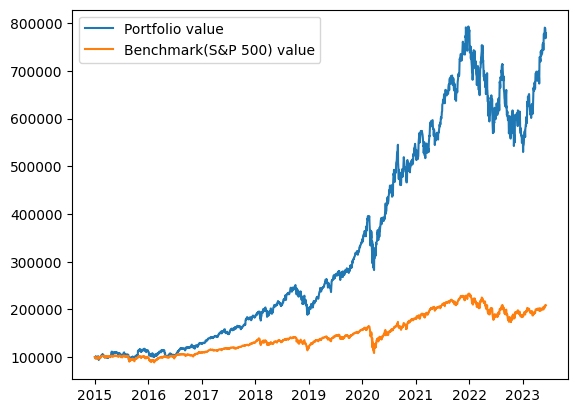

In [24]:
plt.plot(dff.Value, label = 'Portfolio value')
plt.plot(dff.SP, label = 'Benchmark(S&P 500) value')
plt.legend()
plt.show()